#                                      Microsoft Malware Prediction

Importing Packages and loading the dataset.

In [1]:
#Setting up Spark environments with more Memory and loading other packages neede for analysis and modelling.
import os
import seaborn as sns
import time
import pandas as pd
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline, classification
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorIndexer
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.setSystemProperty('spark.driver.memory', '4g')
sc.setSystemProperty('spark.executor.memory', '4g')

%matplotlib inline

In [2]:
#setting dtypes since some of the columns are being read as Objects instead of Categories
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }



In [3]:
#Reading the dataset
from pyspark.sql import DataFrame as sdf
train=spark.read.format("csv").option("header", "true").option("inferSchema", "true").option('dtype',dtypes).load("train.csv").limit(100000)


*Part 1*:  Exploratory Data Analysis

In [ ]:
train.dtypes

Missing values analysis

In [ ]:
%%time
nullAnalysisDF=train.select([(fn.count(fn.when(fn.isnan(c) | fn.col(c).isNull(), c))/1000).alias(c) for c in train.columns])
nullPD=nullAnalysisDF.select('*').toPandas()
nullPD=nullPD.transpose()
badcol=nullPD.sort_values(0,ascending=False).head(15).iloc[0:15]
badcol

*Part 2:* Data Cleaning

In [4]:
#Filling some columns with their most frequent values
train=train.fillna("RequireAdmin",subset=["SmartScreen"])
train=train.fillna(27.0,subset=["OrganizationIdentifier"])

In [5]:
%%time
nullAnalysisDF=train.select([(fn.count(fn.when(fn.isnan(c) | fn.col(c).isNull(), c))/1000).alias(c) for c in train.columns])
nullPD=nullAnalysisDF.select('*').toPandas()
nullPD=nullPD.transpose()
badcol=nullPD.sort_values(0,ascending=False).head(15).iloc[0:15]

Wall time: 27 s


In [7]:
badcol

,0
PuaMode,99.969
Census_ProcessorClass,99.573
DefaultBrowsersIdentifier,95.110
Census_IsFlightingInternal,83.163
Census_InternalBatteryType,71.240
Census_ThresholdOptIn,63.738
Census_IsWIMBootEnabled,63.659
SMode,5.932
CityIdentifier,3.615
Wdft_IsGamer,3.415


In [6]:
badcolnames=list(badcol.index)
badcolnames

['PuaMode',
 'Census_ProcessorClass',
 'DefaultBrowsersIdentifier',
 'Census_IsFlightingInternal',
 'Census_InternalBatteryType',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled',
 'SMode',
 'CityIdentifier',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier',
 'Census_InternalBatteryNumberOfCharges',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_IsFlightsDisabled']

In [8]:
train=train.drop('PuaMode',
 'Census_ProcessorClass',
 'DefaultBrowsersIdentifier',
 'Census_IsFlightingInternal',
 'Census_InternalBatteryType',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled',
)

In [9]:
train=train.drop('MachineIdentifier','Census_DeviceFamily')
train=train.dropna()


In [10]:
train.count()

80604

In [11]:
train = train.select( '*', fn.col('HasDetections').alias('label') ).drop('HasDetections')

In [12]:
columnList = [item[0] for item in train.dtypes if item[1].startswith('string')]
columnList

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [ ]:
train.update('')

In [13]:
%%time
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in columnList
]

encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[
        "{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=encoder.getOutputCols(),
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + [encoder])
pipelinemodel =pipeline.fit(train).transform(train)

Wall time: 4min 58s


In [28]:
pipelinemodel.dtypes

[('ProductName', 'string'),
 ('EngineVersion', 'string'),
 ('AppVersion', 'string'),
 ('AvSigVersion', 'string'),
 ('IsBeta', 'int'),
 ('RtpStateBitfield', 'int'),
 ('IsSxsPassiveMode', 'int'),
 ('AVProductStatesIdentifier', 'int'),
 ('AVProductsInstalled', 'int'),
 ('AVProductsEnabled', 'int'),
 ('HasTpm', 'int'),
 ('CountryIdentifier', 'int'),
 ('CityIdentifier', 'int'),
 ('OrganizationIdentifier', 'int'),
 ('GeoNameIdentifier', 'int'),
 ('LocaleEnglishNameIdentifier', 'int'),
 ('Platform', 'string'),
 ('Processor', 'string'),
 ('OsVer', 'string'),
 ('OsBuild', 'int'),
 ('OsSuite', 'int'),
 ('OsPlatformSubRelease', 'string'),
 ('OsBuildLab', 'string'),
 ('SkuEdition', 'string'),
 ('IsProtected', 'int'),
 ('AutoSampleOptIn', 'int'),
 ('SMode', 'int'),
 ('IeVerIdentifier', 'int'),
 ('SmartScreen', 'string'),
 ('Firewall', 'int'),
 ('UacLuaenable', 'int'),
 ('Census_MDC2FormFactor', 'string'),
 ('Census_OEMNameIdentifier', 'int'),
 ('Census_OEMModelIdentifier', 'int'),
 ('Census_Process

In [30]:
pipelinemodel.select("ProductName","ProductName_indexed").distinct().show()

+------------+-------------------+
| ProductName|ProductName_indexed|
+------------+-------------------+
|win8defender|                0.0|
|         mse|                1.0|
+------------+-------------------+



In [14]:
newDF=pipelinemodel.drop('ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing',
 'SmartScreen')

In [15]:
(train1,validate,test)=newDF.randomSplit([0.6, 0.2, 0.2])

In [22]:
inputDF=newDF.limit(1)

In [23]:
inputDF.toPandas()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_PowerPlatformRoleName_indexed_encoded,Census_ActivationChannel_indexed_encoded,AvSigVersion_indexed_encoded,Census_FlightRing_indexed_encoded,SkuEdition_indexed_encoded,Census_OSArchitecture_indexed_encoded,Census_OSVersion_indexed_encoded,Census_OSInstallTypeName_indexed_encoded,Census_GenuineStateName_indexed_encoded,Census_OSSkuName_indexed_encoded
0,0,7,0,53447,1,1,1,29,128035,18,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
train.limit(1).toPandas()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,label
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7,0,53447,1,1,...,628,36144,0,0,0,0,0,0,10,0


In [27]:
colnam = newDF.columns
colnam.remove('label')
len(colnam)

97

In [28]:
pipeline_lr = Pipeline(stages=[feature.VectorAssembler(inputCols=colnam,
                                               outputCol="features"),
                              feature.StandardScaler(inputCol="features", outputCol="scaledFeatures",\
                                                       withStd=True, withMean=True)])
pipelinelogreg = classification.LogisticRegression(elasticNetParam=0,regParam=0,featuresCol='scaledFeatures',labelCol='label')
                              

In [29]:
%%time
model1 = pipeline_lr.fit(train1).transform(train1)
modelligreg = pipelinelogreg.fit(model1)



Wall time: 2min 36s


In [30]:
modelligreg.summary.areaUnderROC

0.767188132504243

In [31]:
coefficients=modelligreg.coefficients

In [31]:
%%time
model5=pipeline_lr.fit(validate).transform(validate)

Wall time: 12.9 s


In [40]:
model5.columns

['IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_IsPortableO

In [32]:
%%time
newDF2=modelligreg.transform(model5)

Wall time: 19 ms


In [38]:
inputdf = newDF2.select('rawPrediction','probability','prediction').limit(1)

In [39]:
inputdf.toPandas()

,rawPrediction,probability,prediction
0,"[1.7756880543194784, -1.7756880543194784]","[0.8551636109285246, 0.14483638907147545]",0.0


In [33]:
newDF2.columns

['IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_IsPortableO

In [62]:
x=list(zip(newDF2.columns,coefficients))
y = pd.DataFrame(x)
y.sort_values(1,ascending=False)

,0,1
56,OsBuildLab_indexed,0.323161
24,Census_PrimaryDiskTotalCapacity,0.182785
3,AVProductStatesIdentifier,0.148517
1,RtpStateBitfield,0.126159
12,OsSuite,0.103831
13,IsProtected,0.099698
45,Wdft_IsGamer,0.093244
2,IsSxsPassiveMode,0.078352
29,Census_InternalPrimaryDisplayResolutionHorizontal,0.069841
73,ProductName_indexed_encoded,0.059795


In [65]:
model5.groupBy('OsBuildLab_indexed').count().show()
#c = [model5.AVProductStatesIdentifier]
#model5.agg( max(model5.AVProductStatesIdentifier))
model5.groupBy('OsBuildLab_indexed').agg({'max'}).show()  
model5.agg({"OsBuildLab_indexed": "min"}).collect()[0]
#max1 = 70459
#min1 = 216

+------------------+-----+
|OsBuildLab_indexed|count|
+------------------+-----+
|               4.0|  461|
|              45.0|   12|
|               2.0| 1729|
|               0.0| 7028|
|              12.0|   74|
|               1.0| 2498|
|               5.0|  399|
|              38.0|   22|
|              47.0|   12|
|             153.0|    2|
|              15.0|   63|
|              92.0|    3|
|               7.0|  322|
|              33.0|   27|
|              24.0|   28|
|               3.0| 1207|
|               6.0|  421|
|              16.0|   58|
|              19.0|   41|
|              65.0|    8|
+------------------+-----+
only showing top 20 rows



AssertionError: all exprs should be Column

In [42]:
model5['AVProductStatesIdentifier'].min()

TypeError: 'Column' object is not callable

In [30]:
[t for t in x if t[1]>0.1]

[('RtpStateBitfield', 0.10305916885065826),
 ('AVProductStatesIdentifier', 0.11823824171486282),
 ('Census_PrimaryDiskTotalCapacity', 0.1670347405373994),
 ('label', 21.04410253539386)]

In [31]:
columnList2 = [item[0] for item in newDF.dtypes if item[1].startswith('string')]
columnList2

[]

In [32]:
newDF.dtypes

[('IsBeta', 'int'),
 ('RtpStateBitfield', 'int'),
 ('IsSxsPassiveMode', 'int'),
 ('AVProductStatesIdentifier', 'int'),
 ('AVProductsInstalled', 'int'),
 ('AVProductsEnabled', 'int'),
 ('HasTpm', 'int'),
 ('CountryIdentifier', 'int'),
 ('CityIdentifier', 'int'),
 ('GeoNameIdentifier', 'int'),
 ('LocaleEnglishNameIdentifier', 'int'),
 ('OsBuild', 'int'),
 ('OsSuite', 'int'),
 ('IsProtected', 'int'),
 ('AutoSampleOptIn', 'int'),
 ('SMode', 'int'),
 ('IeVerIdentifier', 'int'),
 ('Firewall', 'int'),
 ('UacLuaenable', 'int'),
 ('Census_OEMNameIdentifier', 'int'),
 ('Census_OEMModelIdentifier', 'int'),
 ('Census_ProcessorCoreCount', 'int'),
 ('Census_ProcessorManufacturerIdentifier', 'int'),
 ('Census_ProcessorModelIdentifier', 'int'),
 ('Census_PrimaryDiskTotalCapacity', 'decimal(13,0)'),
 ('Census_SystemVolumeTotalCapacity', 'int'),
 ('Census_HasOpticalDiskDrive', 'int'),
 ('Census_TotalPhysicalRAM', 'int'),
 ('Census_InternalPrimaryDiagonalDisplaySizeInInches', 'double'),
 ('Census_Interna

In [33]:
len(newDF.columns)

96

In [34]:
#pipeline_lr2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['Census_OSBranch',
#                              'HasDetections'], outputCol="features"),
#                              feature.VectorIndexer(inputCol="features", outputCol="features_indexed"),
#                              feature.StandardScaler(inputCol="features", outputCol="scaledFeatures",\
#                                                       withStd=True, withMean=True),
#                              regression.LinearRegression(featuresCol='scaledFeatures',labelCol='HasDetections')
#                              ])

In [35]:
#pipeline_lr2.fit(train)

In [38]:
(trainDF,testDF)=newDF.randomSplit([0.8, 0.2])

In [39]:
pipeline_1 = Pipeline(stages=[feature.VectorAssembler(inputCols=colnam, outputCol="features"),
                              feature.VectorIndexer(inputCol="features", outputCol="features_indexed"),
                              feature.StandardScaler(inputCol="features", outputCol="scaledFeatures",\
                                                       withStd=True, withMean=True)])
pipeline_lr3 = classification.RandomForestClassifier(featuresCol='scaledFeatures',labelCol='label',numTrees=30)

In [40]:
%%time
model_feat = pipeline_1.fit(trainDF).transform(trainDF)
model2 = pipeline_lr3.fit(model_feat)

Wall time: 6min 33s


In [39]:
model2.numTrees

Param(parent=u'RandomForestClassifier_40238a766c6c', name='numTrees', doc='Number of trees to train (>= 1)')

In [40]:
FI=model2.featureImportances

In [41]:
FI

SparseVector(3145, {1: 0.0077, 2: 0.0049, 3: 0.062, 4: 0.0447, 6: 0.0003, 7: 0.0021, 8: 0.0023, 9: 0.002, 10: 0.0005, 12: 0.0002, 13: 0.0163, 16: 0.0072, 19: 0.0021, 20: 0.0029, 21: 0.0254, 23: 0.0028, 24: 0.0029, 25: 0.0288, 26: 0.0003, 27: 0.0445, 28: 0.0192, 29: 0.0056, 30: 0.0021, 31: 0.0017, 32: 0.0209, 33: 0.0009, 34: 0.0001, 35: 0.0003, 38: 0.001, 39: 0.0002, 40: 0.0002, 41: 0.0003, 42: 0.0019, 44: 0.0306, 45: 0.0167, 46: 0.0018, 47: 0.1148, 49: 0.0018, 50: 0.02, 51: 0.0324, 52: 0.0007, 53: 0.0047, 55: 0.0137, 56: 0.0106, 57: 0.0005, 58: 0.0019, 59: 0.0035, 60: 0.0054, 61: 0.0013, 62: 0.0075, 63: 0.0089, 64: 0.0072, 65: 0.0073, 66: 0.0001, 67: 0.0024, 69: 0.0005, 70: 0.002, 71: 0.0012, 73: 0.0081, 75: 0.0191, 77: 0.0011, 78: 0.0001, 80: 0.0003, 81: 0.0136, 84: 0.0065, 92: 0.0002, 107: 0.0002, 153: 0.0079, 156: 0.0003, 157: 0.0052, 158: 0.0023, 160: 0.0003, 162: 0.0013, 167: 0.0004, 172: 0.0004, 173: 0.0002, 174: 0.0, 179: 0.0003, 187: 0.0004, 198: 0.0008, 208: 0.0003, 257: 0.0, 

In [42]:
final1 = model2.transform(model_feat)

In [43]:
from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*final1
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

In [44]:
a = [(name, model2.featureImportances[idx])
 for idx, name in attrs
 if model2.featureImportances[idx]]

In [45]:
ab = pd.DataFrame(a)

In [46]:
ab.sort_values(1,ascending=False)

,0,1
36,label,0.114783
2,AVProductStatesIdentifier,0.062032
3,AVProductsInstalled,0.044657
19,Census_TotalPhysicalRAM,0.044532
226,Census_OSArchitecture_indexed_encoded_x86,0.036890
121,EngineVersion_indexed_encoded_1.1.14901.4,0.036599
39,AvSigVersion_indexed,0.032413
33,Census_IsAlwaysOnAlwaysConnectedCapable,0.030647
225,Census_OSArchitecture_indexed_encoded_amd64,0.030396
17,Census_SystemVolumeTotalCapacity,0.028809


In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#x=model2.stages[3]
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(final1)

0.9217073643065653

In [48]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
numFolds = 2
evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder().addGrid(pipeline_lr3.numTrees,[10,20,30,40]).build())

crossval = CrossValidator(
    estimator=pipeline_lr3,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

In [49]:
%%time
model = crossval.fit(model_feat)

Wall time: 5min 25s


In [25]:
model_feat.count()

64541

In [51]:
model.params

[Param(parent=u'CrossValidatorModel_29b989813c04', name='estimator', doc='estimator to be cross-validated'),
 Param(parent=u'CrossValidatorModel_29b989813c04', name='estimatorParamMaps', doc='estimator param maps'),
 Param(parent=u'CrossValidatorModel_29b989813c04', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'),
 Param(parent=u'CrossValidatorModel_29b989813c04', name='seed', doc='random seed.')]

In [26]:
%%time
prediction = model.transform(model_feat)

Wall time: 41 ms


In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(prediction)

0.938143574215076

In [29]:
%%time
model_testDF = pipeline_1.fit(testDF).transform(testDF)

Wall time: 41.2 s


In [30]:
testprediction = model.transform(model_testDF)

In [31]:
%%time
evaluator.evaluate(testprediction)

Wall time: 13.7 s


0.935653787598384

In [51]:
dtypestest = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        
        }


In [61]:
%%time
testdf=spark.read.format("csv").option("header", "true").option("inferSchema", "true").option('dtype',dtypestest).load("test.csv")

Wall time: 16.3 s


In [53]:
nullAnalysisDFtest=testdf.select([(fn.count(fn.when(fn.isnan(c) | fn.col(c).isNull(), c))/1000).alias(c) for c in testdf.columns])

In [54]:
nullPDtest=nullAnalysisDFtest.select('*').toPandas()


In [55]:
nullPDtest=nullPDtest.transpose()


In [56]:
nullPDtest

,0
MachineIdentifier,0.000
ProductName,0.000
EngineVersion,0.000
AppVersion,0.000
AvSigVersion,0.000
IsBeta,0.000
RtpStateBitfield,32.222
IsSxsPassiveMode,0.000
DefaultBrowsersIdentifier,7546.134
AVProductStatesIdentifier,23.767


In [57]:
badcoltest=nullPD.sort_values(0,ascending=False).head(9).iloc[0:9]
badcoltest
badcolnamestest =list(badcoltest.index)
badcolnamestest

['PuaMode',
 'Census_ProcessorClass',
 'DefaultBrowsersIdentifier',
 'Census_IsFlightingInternal',
 'Census_InternalBatteryType',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled',
 'SmartScreen',
 'OrganizationIdentifier']

In [58]:
testdfclean=testdf.select('ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_IsPortableOperatingSystem',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_IsFlightsDisabled',
 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier')

In [60]:
testdfclean.count()

1649601

In [70]:
pipeline_gb1 = Pipeline(stages=[feature.VectorAssembler(inputCols=colnam, outputCol="features"),
                              feature.VectorIndexer(inputCol="features", outputCol="features_indexed"),
                              feature.StandardScaler(inputCol="features", outputCol="scaledFeatures",\
                                                       withStd=True, withMean=True)])
pipeline_gb2 = classification.GBTClassifier(featuresCol='scaledFeatures',labelCol='label',maxIter=10)

(trainDFgb,validDFgb,testDFgb)=newDF.randomSplit([0.6,0.2, 0.2])

In [77]:
gbmodel_feat = pipeline_gb1.fit(trainDFgb).transform(trainDFgb)
gbmodel2 = pipeline_gb2.fit(gbmodel_feat)

In [72]:
FI_gb =gbmodel2.featureImportances

In [73]:
FI_gb

SparseVector(3145, {12: 0.0, 15: 0.0, 19: 0.0, 36: 0.0, 47: 1.0, 51: 0.0, 61: 0.0, 66: 0.0, 67: 0.0, 107: 0.0, 110: 0.0, 111: 0.0, 115: 0.0, 116: 0.0, 117: 0.0, 121: 0.0, 125: 0.0, 155: 0.0, 164: 0.0, 168: 0.0, 169: 0.0, 182: 0.0, 225: 0.0, 234: 0.0, 428: 0.0, 430: 0.0, 431: 0.0, 438: 0.0, 446: 0.0, 449: 0.0, 451: 0.0, 461: 0.0, 520: 0.0, 693: 0.0, 1045: 0.0, 1139: 0.0, 1205: 0.0, 1530: 0.0, 1668: 0.0, 2160: 0.0, 2888: 0.0, 2908: 0.0, 2965: 0.0, 2989: 0.0, 3005: 0.0, 3124: 0.0, 3131: 0.0})

In [78]:
gbmodel_featvalid = pipeline_gb1.fit(validDFgb).transform(validDFgb)

In [80]:

gbmodelvalid = gbmodel2.transform(gbmodel_featvalid)


evaluator_gb = BinaryClassificationEvaluator()

evaluator_gb.evaluate(gbmodelvalid)



1.0

In [81]:
gbmodel_feattest = pipeline_gb1.fit(testDFgb).transform(testDFgb)

In [82]:
gbmodeltest= gbmodel2.transform(gbmodel_feattest)


evaluator_gbtest = BinaryClassificationEvaluator()

evaluator_gbtest.evaluate(gbmodeltest)



1.0

In [ ]:
model.avgMetrics[0]

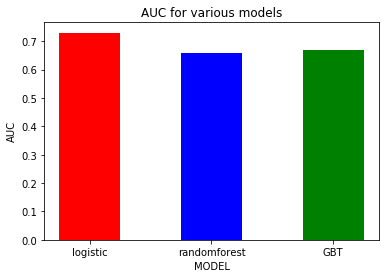

In [35]:
plt.bar(['logistic','randomforest','GBT'], [0.73,0.66,0.67], width=0.5, align='center',color=['r','b','g'])
plt.xlabel("MODEL")
plt.ylabel("AUC")
plt.title("AUC for various models")
plt.show()